In [15]:
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.centrality as centrality

In [16]:
def get_value(name, maps):
    for nodes in maps:
        if nodes["name"] == name:
            return nodes["value"]

def get_info(data):
    connections = defaultdict(int)
    interactions = defaultdict(int)
    for link in data["links"]:
        connections[data["nodes"][link["source"]]["name"]] += 1
        connections[data["nodes"][link["target"]]["name"]] += 1
        interactions[data["nodes"][link["source"]]["name"]] += link["value"]
        interactions[data["nodes"][link["target"]]["name"]] += link["value"]
    return connections, interactions
   
def get_betweenness(data):
    nodes = [ node['name'] for node in data["nodes"] ]
    edges = [ (nodes[link['source']], nodes[link['target']]) for link in data["links"] ]
    G = nx.Graph()
    for node in nodes:
        G.add_node(node)
    for edge in edges:
        G.add_edge(edge[0],edge[1])
    plt.figure(figsize=(30,15))
    plt.subplot(121)
    nx.draw(G, with_labels=True)
    return sorted(centrality.betweenness_centrality(G).items(), key = lambda x: x[1])[::-1]

In [17]:
def get_homophily(data, characters):
    sides = []
    for side in characters.values():
        arr = []
        for count in range(len(data["nodes"])):
            if data["nodes"][count]["name"] in side:
                arr.append(count)
        sides.append(arr)
    
    homophily = []
    for side in sides:
        interacts = defaultdict(int)
        for link in data["links"]:
            if link["source"] in side:
                interacts[data["nodes"][link["target"]]["name"]] += link["value"]
                interacts[data["nodes"][link["source"]]["name"]] += link["value"]
            elif link["target"] in side:
                interacts[data["nodes"][link["source"]]["name"]] += link["value"]
                interacts[data["nodes"][link["target"]]["name"]] += link["value"]
        homophily.append(sorted(interacts.items(), key = lambda x: x[1])[::-1][:10])
    return homophily
                
def light_dark_classification(data, sides):
    light_side = []
    dark_side = []
    for i,j in sides.items():
        if j == '1':
            light_side.append(i)
        else:
            dark_side.append(i)
    
    sides = []
    for side in [light_side, dark_side]:
        arr = []
        for count in range(len(data["nodes"])):
            if data["nodes"][count]["name"] in side:
                arr.append(count)
        sides.append(arr)

    good = defaultdict(int)
    bad = defaultdict(int)
    for character in sides[0]:
        for link in data["links"]:
            if (link["source"] == character and link["target"] in sides[0]) or (link["target"] == character and link["source"] in sides[0]):
                good[data["nodes"][character]["name"]] += link["value"]/len(sides[0])  
            elif (link["source"] == character and link["target"] in sides[1]) or (link["target"] == character and link["source"] in sides[1]):
                bad[data["nodes"][character]["name"]] += link["value"]/len(sides[1])

    for elem in good.keys():
        if elem not in bad.keys():
            bad[elem] = 0

    for elem in bad.keys():
        if elem not in good.keys():
            good[elem] = 0

    correct = 0
    incorrect = 0
    for l, d in zip(sorted(good.items()), sorted(bad.items())):
        if l[1] >= d[1]:
            if l[0] in light_side:
                correct += 1
            else:
                incorrect += 1
        else:
            if d[0] in dark_side:
                correct += 1
            else:
                incorrect += 1

    return (correct, incorrect)

In [18]:
def loop(episode, feature, betweenness, degree_centrality):
    with open(f'data/starwars-episode-{episode}-{feature}.json') as f:
        data = json.load(f)
    connections, interractions = get_info(data)
    
#     Task 2 Hypothesis 1
    characters = {
        "Light Side": ["FINN", "OBI-WAN", "YODA", "PADME", "LUKE"], 
        "Dark Side": ["EMPEROR","DARTH VADER", "PIETT", "GENERAL HUX", "NUTE GUNRAY"]
    }    
    homophily = get_homophily(data, characters)
    
    with open('myfile.json') as d:
        sides = json.load(d)

    classification = light_dark_classification(data, sides)
    
#     Task 4
    temp = set()
    for i,j in zip(connections.items(), interractions.items()):
        temp.add((i[0], i[1], j[1], get_value(i[0], data["nodes"])))
    temp = sorted(temp, key = lambda x: x[1])[::-1]
    plt.figure(figsize=(25,10))
    plt.title(f'Episode-{episode} {feature}')
    plt.plot(list(zip(*temp))[0], list(zip(*temp))[1], list(zip(*temp))[0], list(zip(*temp))[2], list(zip(*temp))[0], list(zip(*temp))[3])
    plt.xticks(list(zip(*temp))[0][::1],  rotation='vertical')
#     plt.savefig(f'Episode_{episode}_{feature}.png')
    plt.show()

#     Task 2 Hypothesis 2
    if feature == "interactions-allCharacters":
        degree_centrality.append(sorted(connections.items(), key = lambda x: x[1])[::-1][:5])
        betweenness.append(get_betweenness(data)[:5])
    return betweenness, degree_centrality, homophily, classification

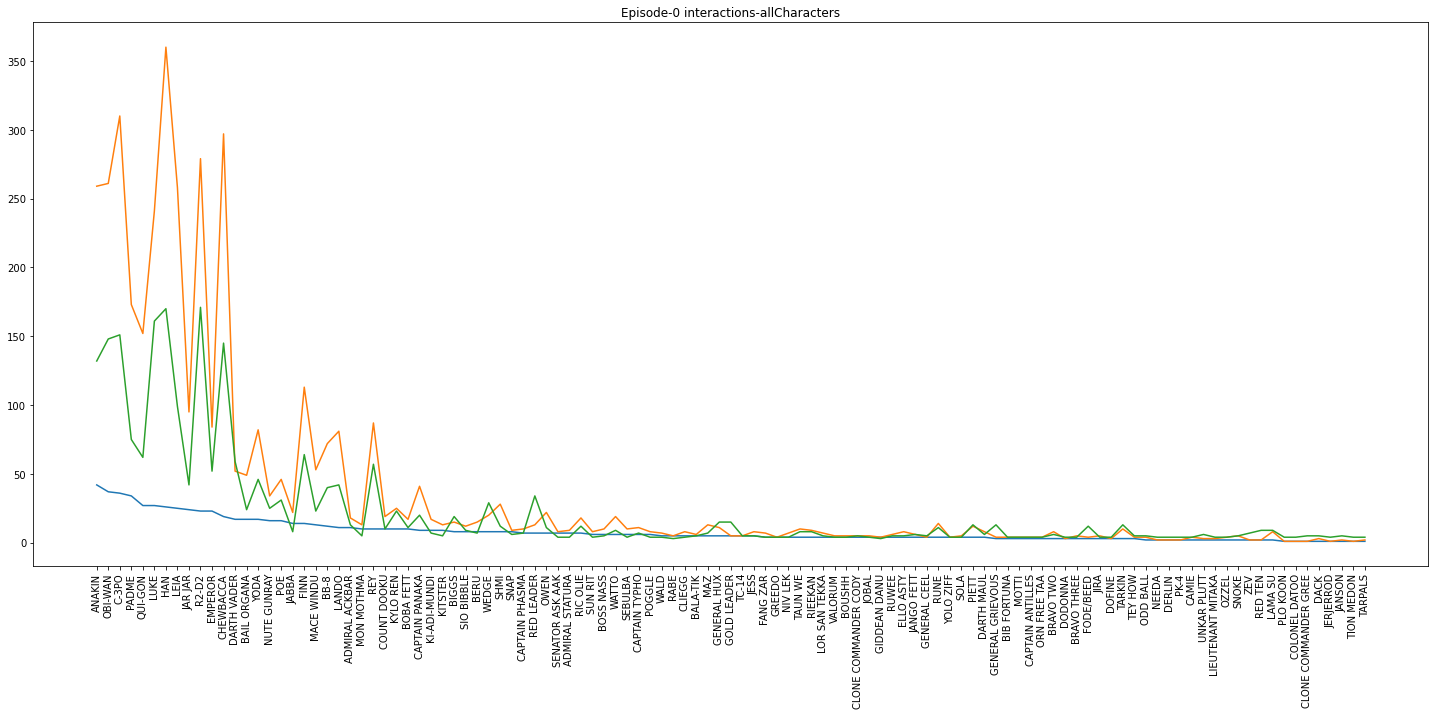

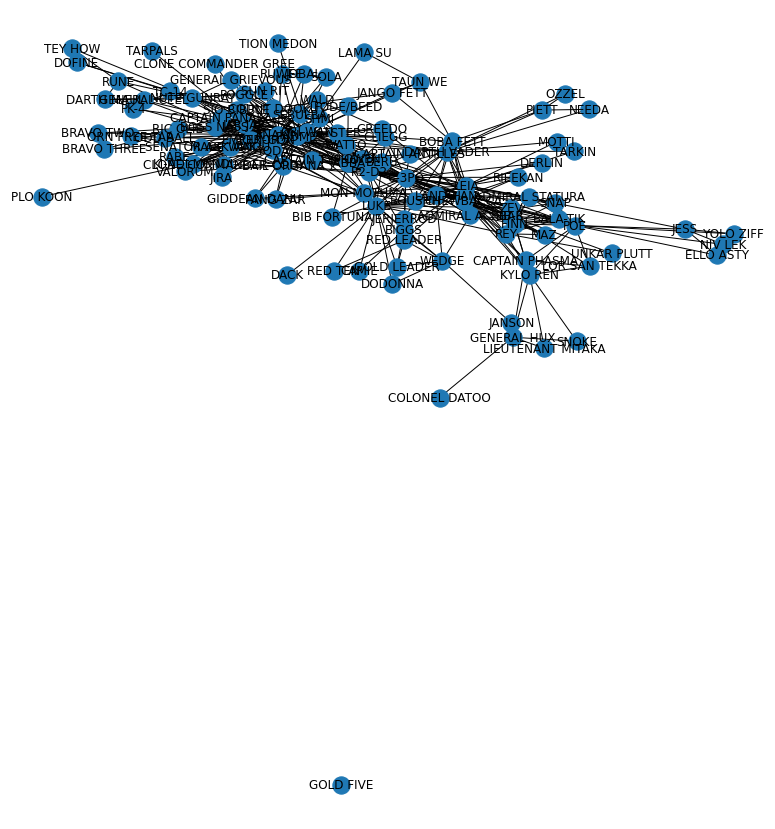

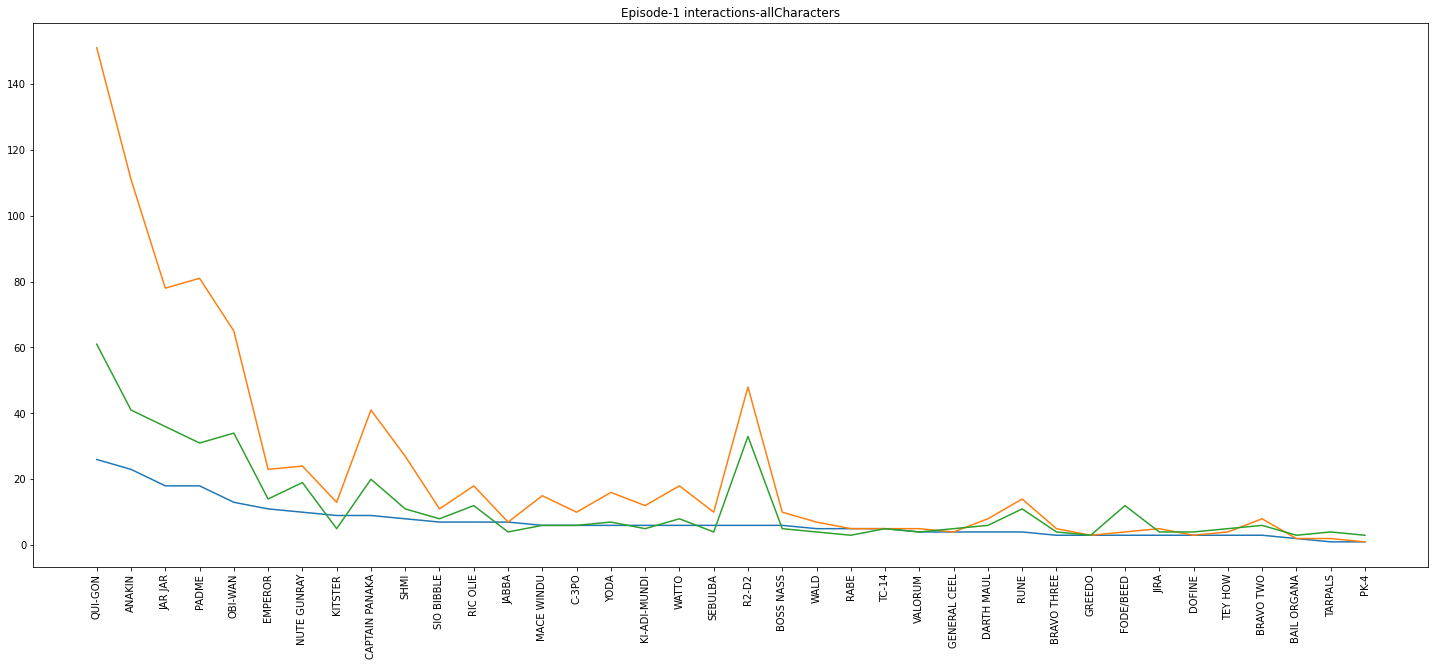

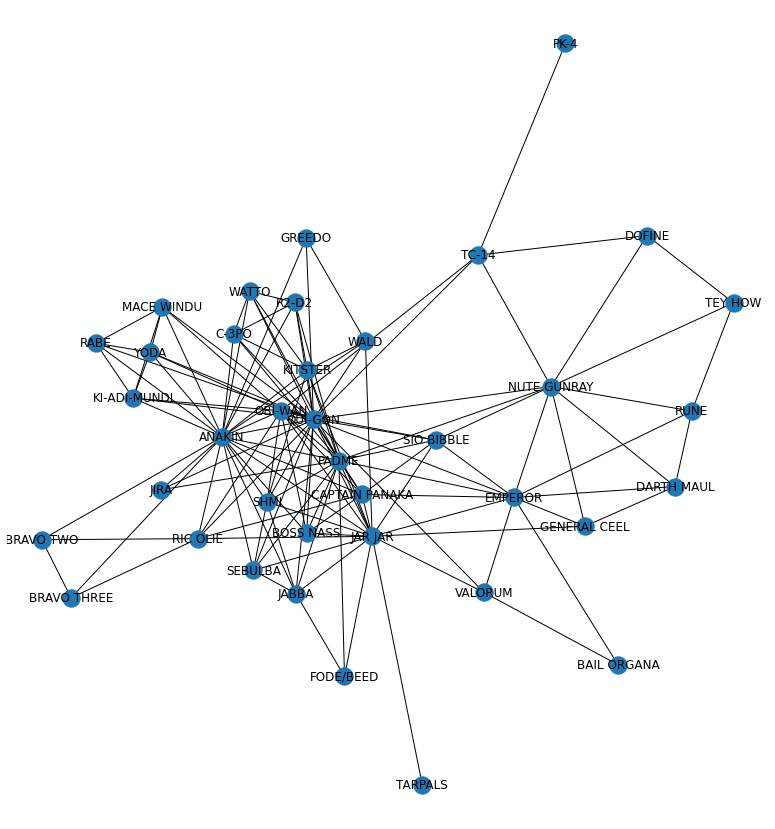

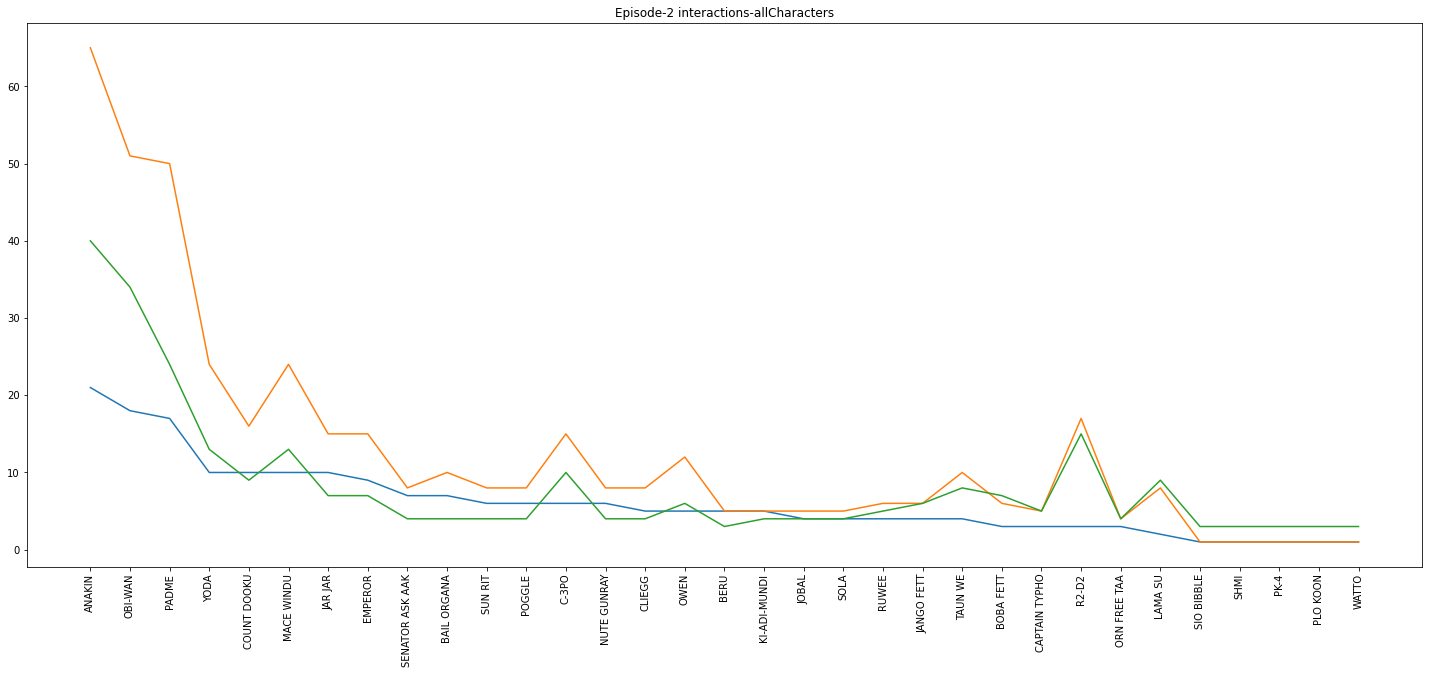

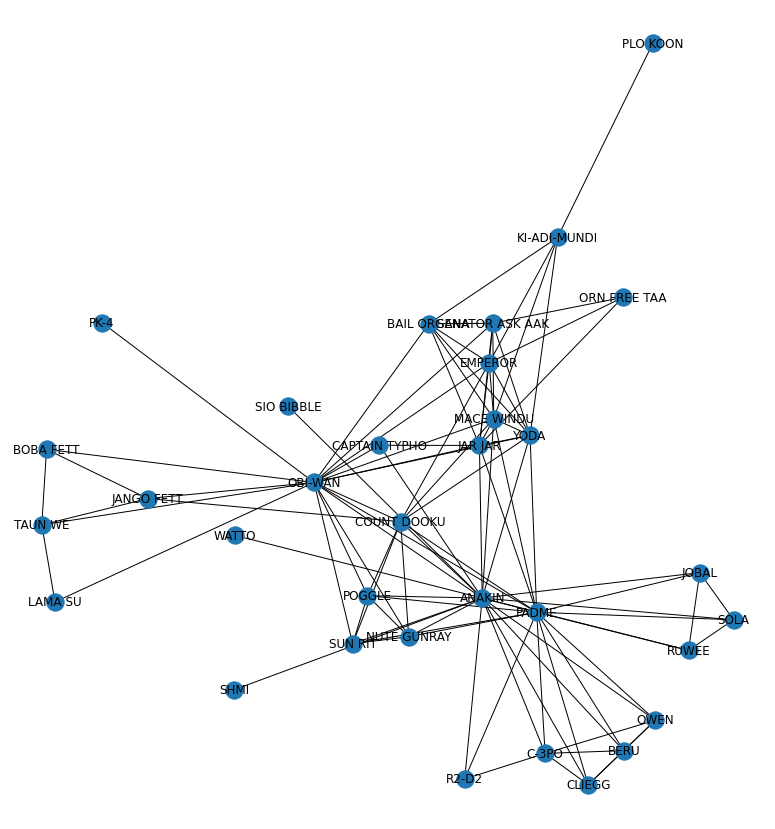

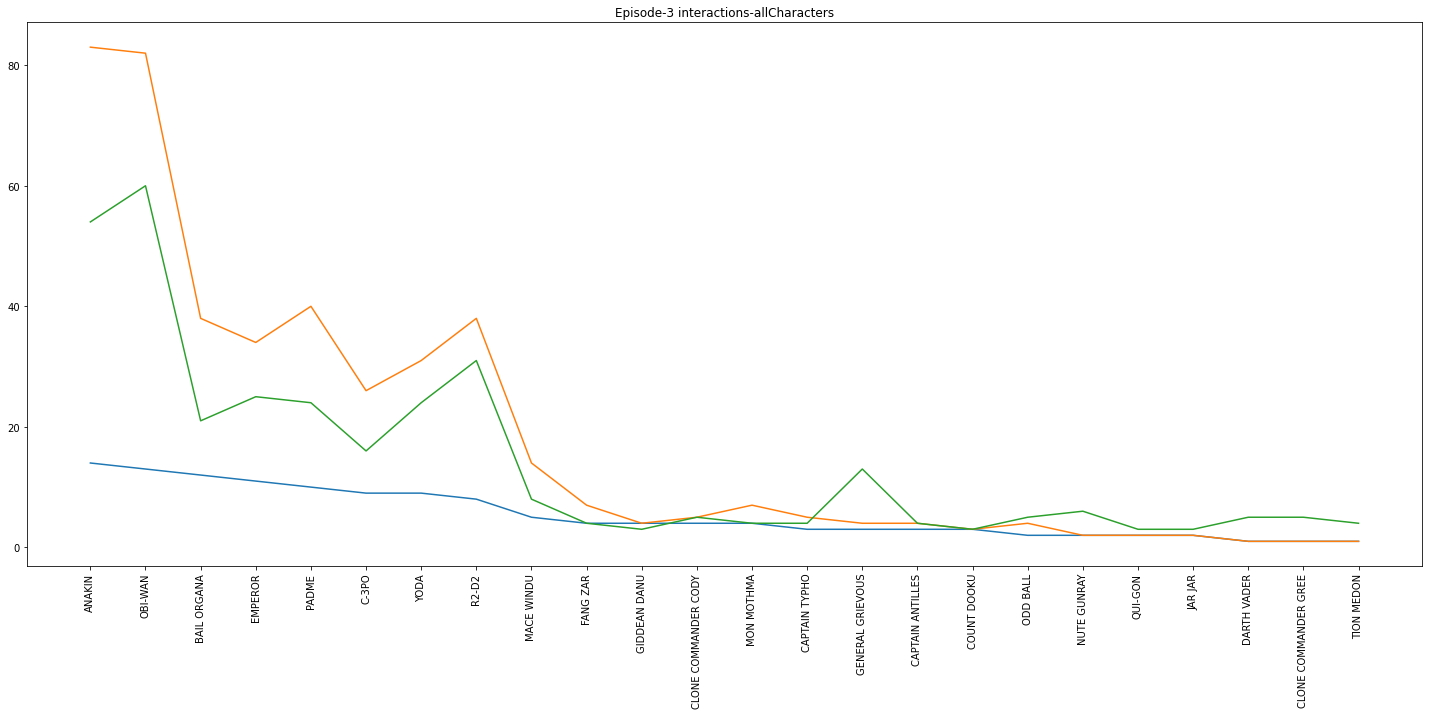

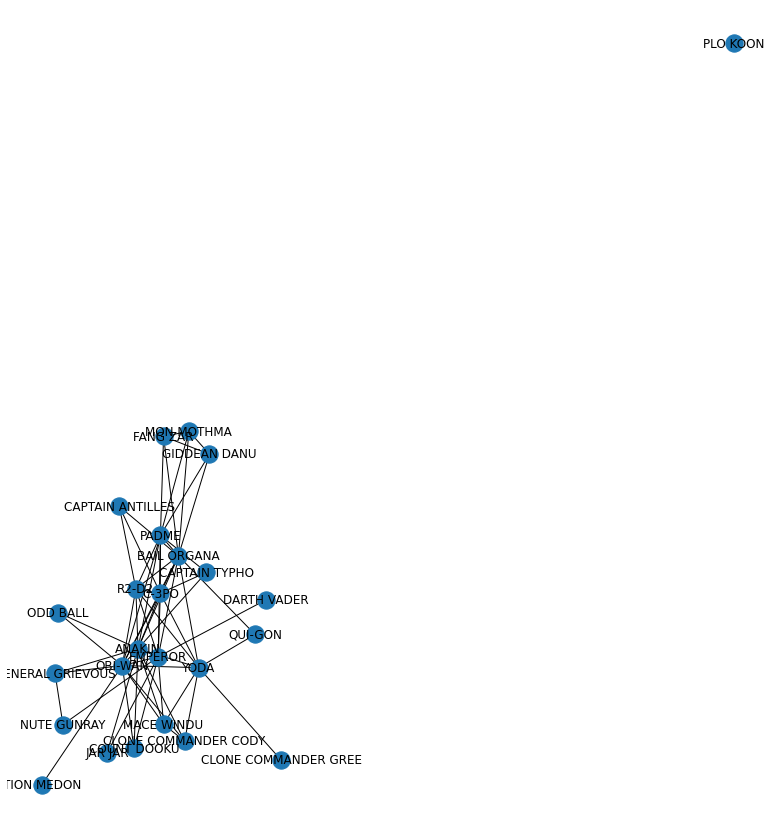

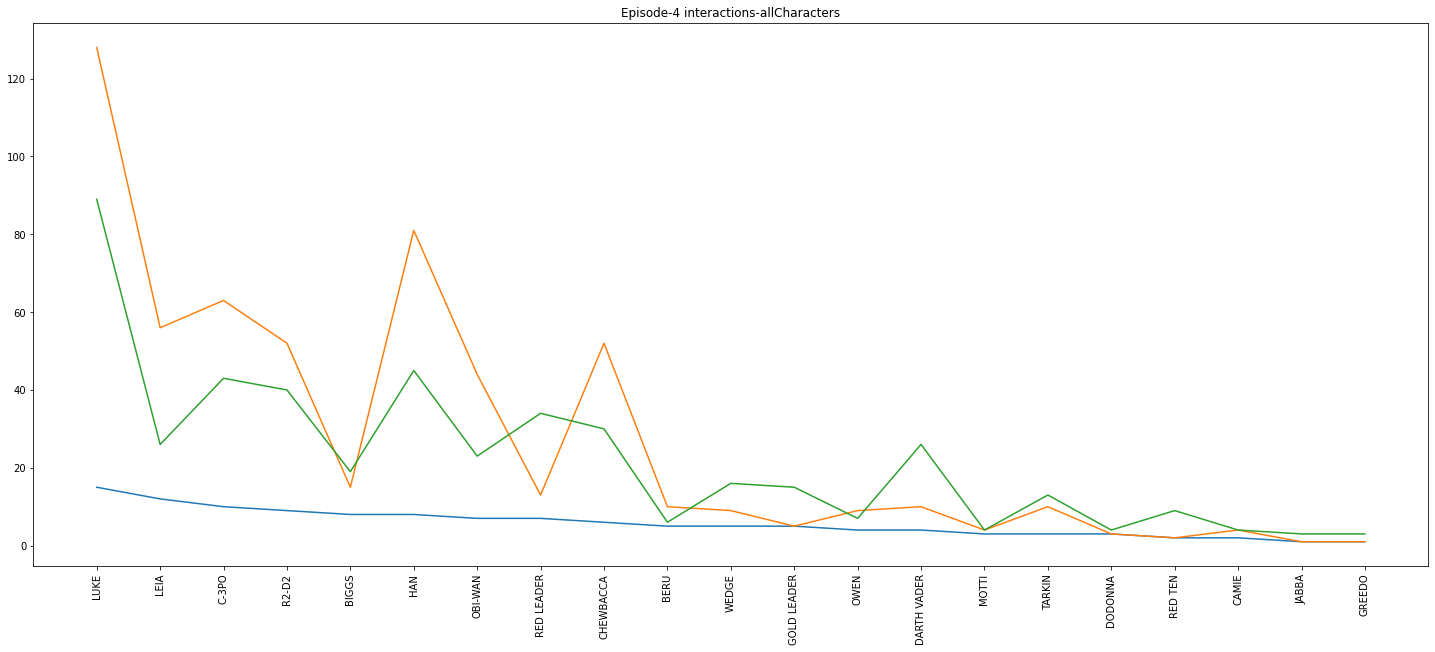

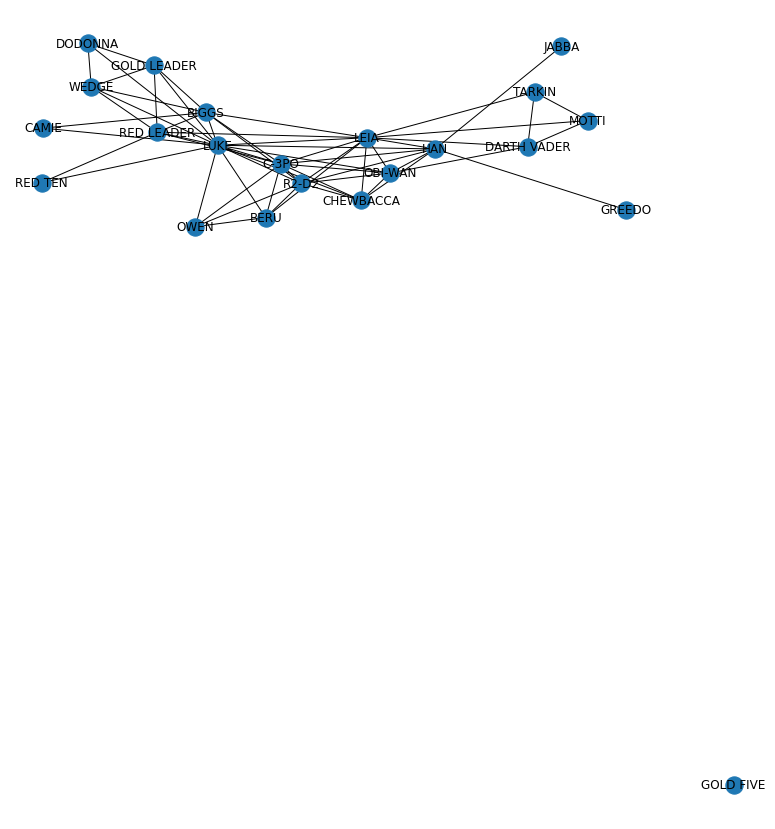

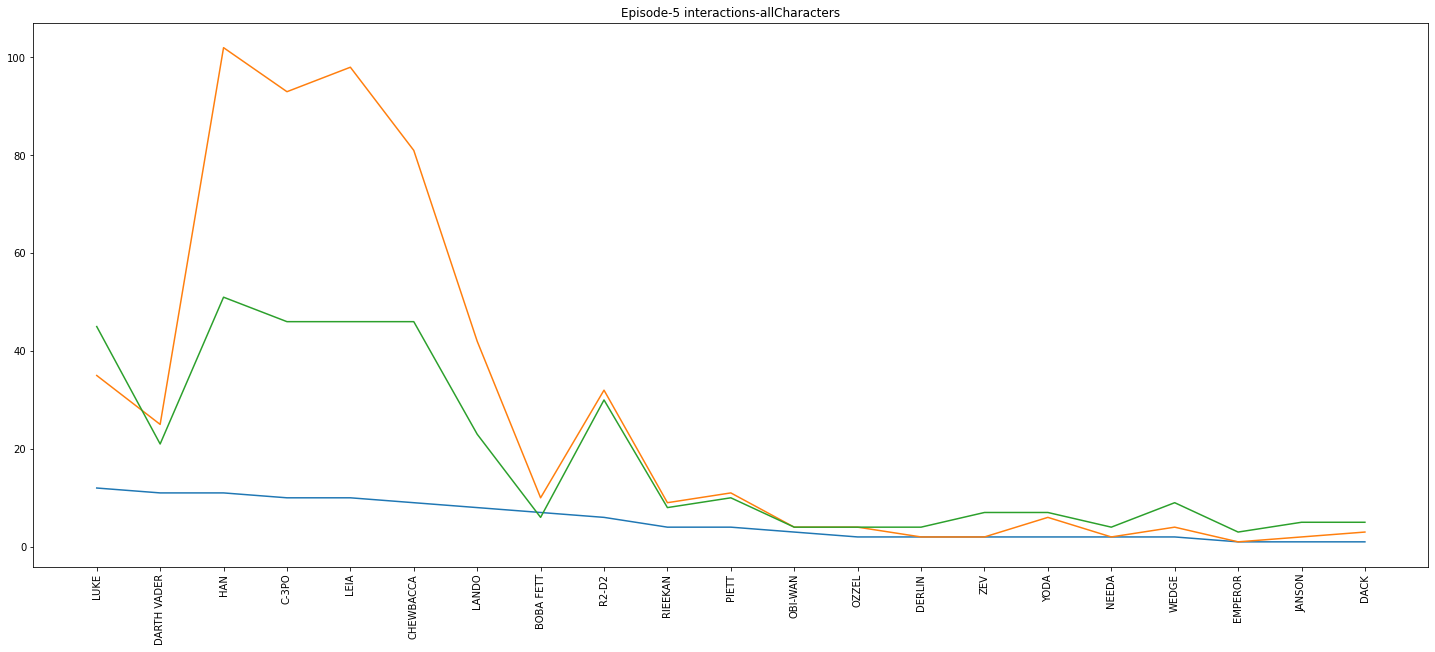

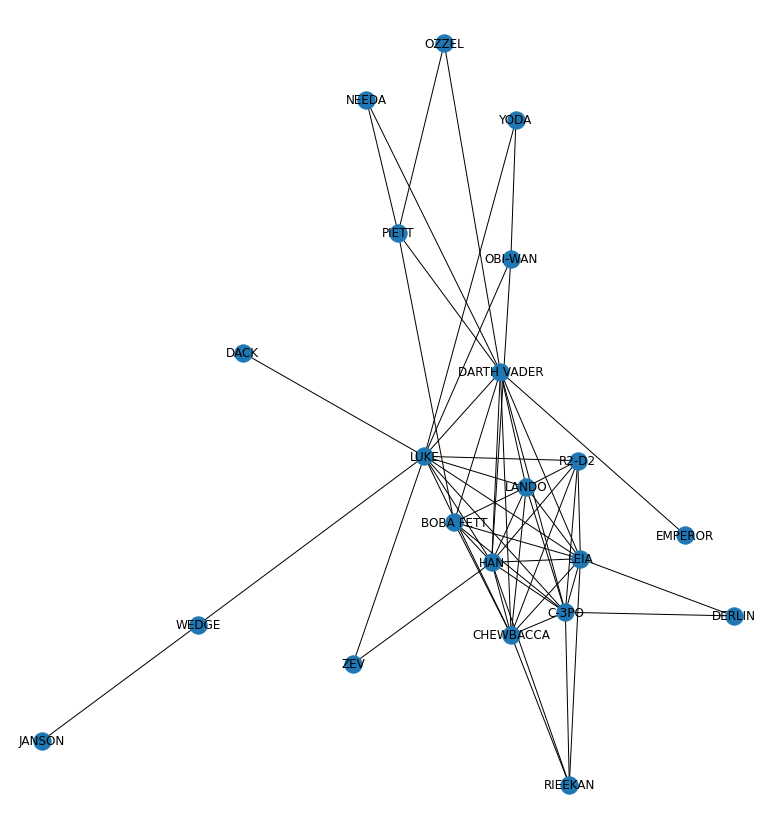

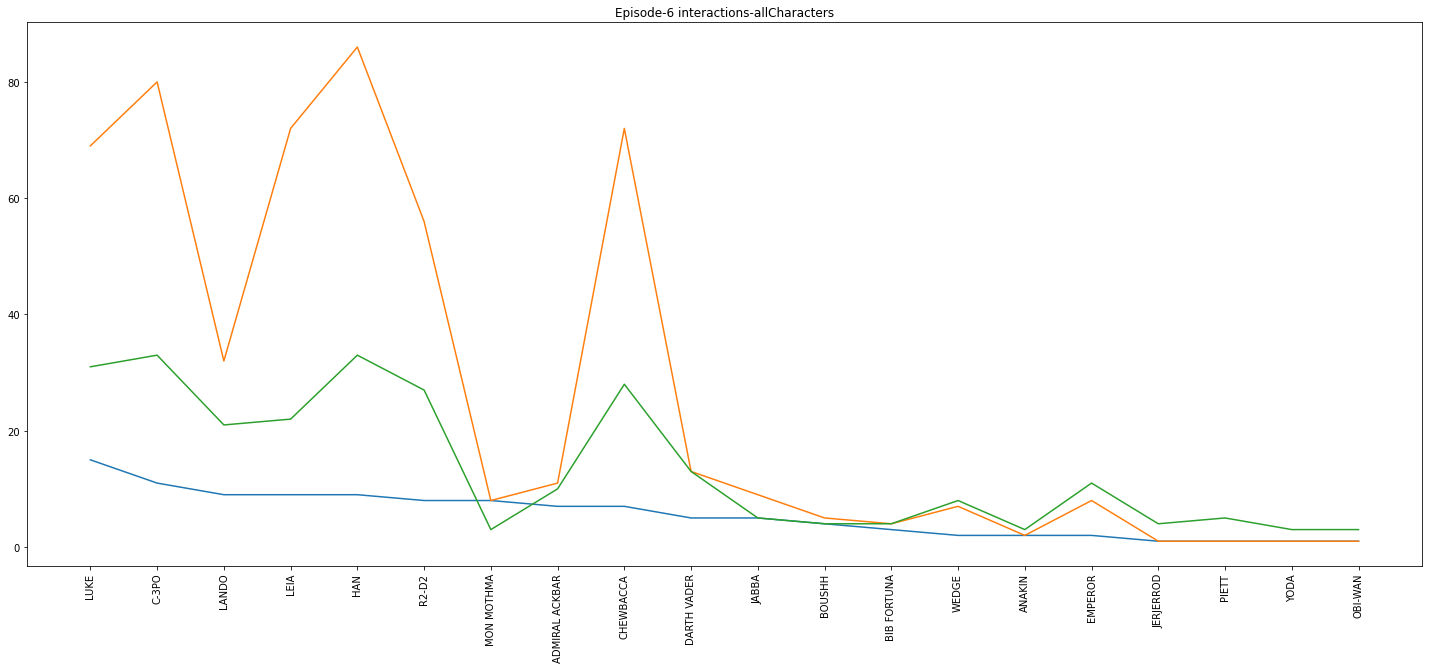

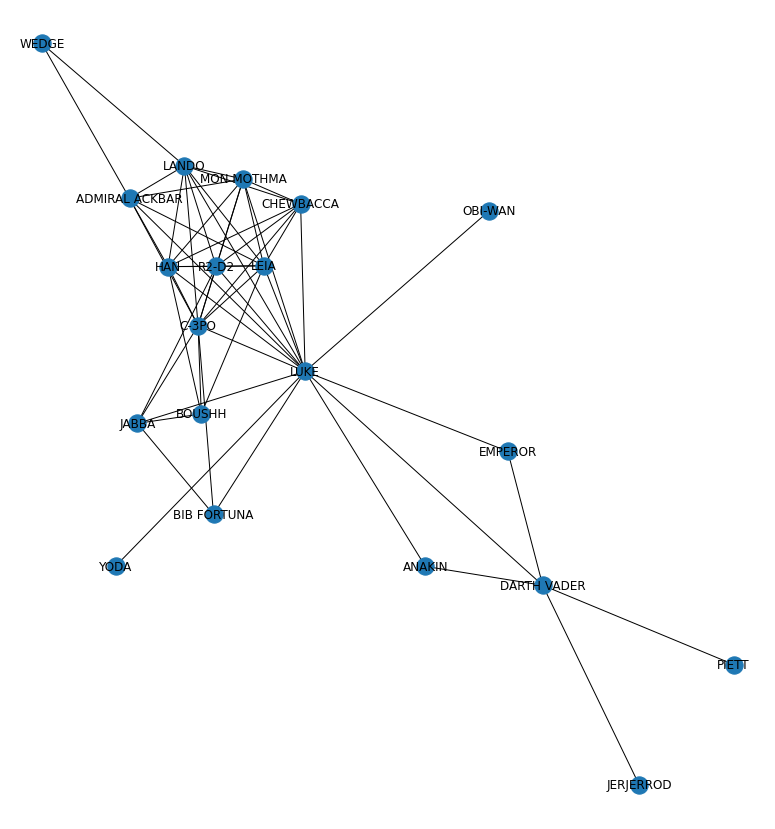

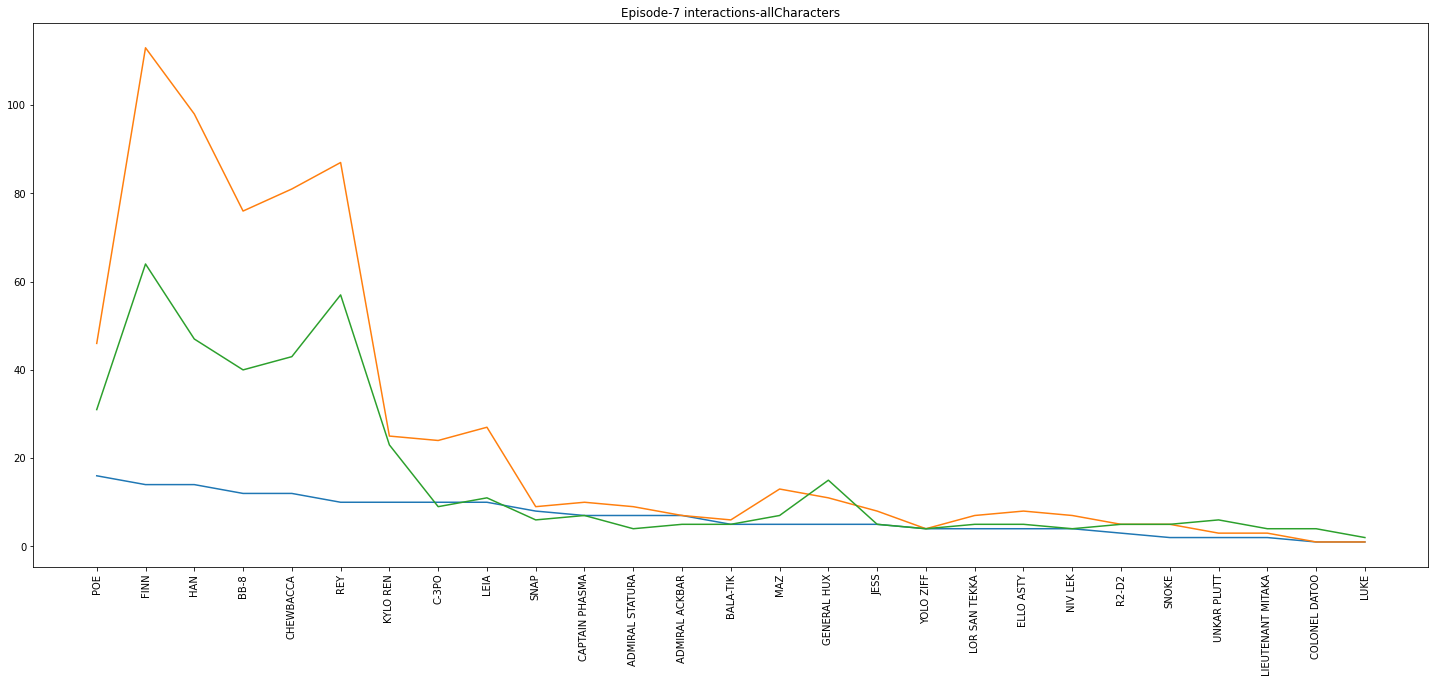

In [ ]:
if __name__ == "__main__":
    features = ["interactions-allCharacters", "mentions"]
    # considering episode 0 as full series
    betweenness = []
    degree_centrality = []
    homophily = []
    classification = []
    for feature in features:
        for i in range(0,8):
            betweenness, degree_centrality, homo, classify = loop(i, feature, betweenness, degree_centrality)
            homophily.append(homo)
            classification.append(classify)


In [ ]:
betweenness

In [ ]:
degree_centrality

In [ ]:
homophily

In [ ]:
classification